# Classification Model Testing From ResNet Model

The following is a series of tests done using a ResNet model that was trained over the GPU server, using the UBIRIS_V2 dataset.

In [ ]:
!pip install tensorflow
!pip install opencv-python


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
from torch.utils.data import WeightedRandomSampler


In [ ]:
# Load your saved model using torch.load()
model_path = '/content/drive/MyDrive/ML final project/Trained_models/Classifier/ResNet_best_eye_color_classifier.pth'
loaded_state_dict = torch.load(model_path, map_location=torch.device('cpu'))

# Set the model to evaluation mode
#loaded_model.eval()

<ipython-input-4-911f54fa329a>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_state_dict = torch.load(model_path, map_location=torch.device('cpu'))


# ResNet Test 1
Using resnet50, a test was done to upload, preprocess, and classify images

In [ ]:
# Load pre-trained ResNet50 model with ImageNet weights
model = ResNet50(weights='imagenet')


102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
from google.colab import files
uploaded = files.upload()

# Load the uploaded image
img_path = next(iter(uploaded))  # Get the first uploaded image


KeyboardInterrupt: 

In [ ]:
# Load and preprocess the image for ResNet50
img = image.load_img(img_path, target_size=(224, 224))  # Resize to 224x224 (required by ResNet)
img_array = image.img_to_array(img)  # Convert image to array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = preprocess_input(img_array)  # Preprocess the image for ResNet50


NameError: name 'img_path' is not defined

In [ ]:
# Predict the class of the image
predictions = model.predict(img_array)

# Decode the predictions to human-readable labels
decoded_predictions = decode_predictions(predictions, top=3)[0]

# Print the top 3 predictions
for i, (imagenet_id, label, score) in enumerate(decoded_predictions):
    print(f"{i+1}: {label} ({score:.2f})")


In [ ]:
1: spotted_dove (0.95)
2: ringed_plover (0.02)
3: eggplant (0.01)


In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Remove the top layer and add a new custom layer
x = model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer
x = Dense(512, activation='relu')(x)  # Fully connected layer
x = Dense(num_eye_colors, activation='softmax')(x)  # Softmax output layer for eye color classification

# Create the new model
custom_model = tf.keras.Model(inputs=model.input, outputs=x)

# Freeze the layers of ResNet50 and train only the new layers
for layer in model.layers:
    layer.trainable = False

# Compile and train the model
custom_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# ResNet Test 2

Below is code used to load a trained model ResNet, that used the UBIRIS_v2 data for training and validation.

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import torch.nn as nn
import torchvision.models as models

class EyeColorPredictor:
    def __init__(self, model_path):
        # Load the saved model and mapping
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        checkpoint = torch.load(model_path, map_location=self.device)

        # Get the color mapping
        self.color_to_idx = checkpoint['color_to_idx']
        self.idx_to_color = {v: k for k, v in self.color_to_idx.items()}

        # Initialize and load the model
        self.model = self.setup_model(len(self.color_to_idx))
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()

        # Setup image transforms
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

    def setup_model(self, num_classes):
        model = models.resnet50(pretrained=False)
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, num_classes)
        )
        model = model.to(self.device)
        return model

    def predict(self, image_path):
        """
        Predict eye color from an image

        Args:
            image_path (str): Path to the image file

        Returns:
            tuple: (predicted_color, confidence_score)
        """
        # Load and preprocess the image
        try:
            image = Image.open(image_path).convert('RGB')
            image_tensor = self.transform(image).unsqueeze(0).to(self.device)

            # Get prediction
            with torch.no_grad():
                outputs = self.model(image_tensor)
                probabilities = torch.nn.functional.softmax(outputs, dim=1)

                # Get the predicted class and confidence
                confidence, predicted = torch.max(probabilities, 1)
                predicted_color = self.idx_to_color[predicted.item()]
                confidence_score = confidence.item()

                # Get top-3 predictions
                top3_prob, top3_indices = torch.topk(probabilities, 3)
                top3_predictions = [
                    (self.idx_to_color[idx.item()], prob.item())
                    for idx, prob in zip(top3_indices[0], top3_prob[0])
                ]

                return {
                    'predicted_color': predicted_color,
                    'confidence': confidence_score,
                    'top3_predictions': top3_predictions
                }

        except Exception as e:
            return f"Error processing image: {str(e)}"

def main():
    # Initialize predictor
    model_path = '/content/drive/MyDrive/ML final project/Trained_models/Classifier/ResNet_best_eye_color_classifier2.pth'
    predictor = EyeColorPredictor(model_path)

    # Example usage
    #while True:
    image_path = ('/content/drive/MyDrive/ML final project/our_eyes/IMG_1636.JPG') #Mcihael
    #image_path = ('/content/drive/MyDrive/ML final project/our_eyes/IMG_1644.JPG') #Esra
    #image_path = ('/content/drive/MyDrive/ML final project/our_eyes/IMG_1650.JPG') #Aeyva
    #if not image_path:
    #    continue

    # Make prediction
    result = predictor.predict(image_path)

    if isinstance(result, dict):
        print("\nResults:")
        print(f"Predicted Eye Color: {result['predicted_color']}")
        print(f"Confidence: {result['confidence']*100:.2f}%")

        print("\nTop 3 Predictions:")
        for color, prob in result['top3_predictions']:
            print(f"{color}: {prob*100:.2f}%")
    else:
        print(result)

if __name__ == "__main__":
    main()

<ipython-input-2-f1e24c1775c2>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=self.device)
/usr/local/lib/python3.10/dist


Results:
Predicted Eye Color: brown
Confidence: 47.01%

Top 3 Predictions:
brown: 47.01%
hazel: 27.46%
blue: 11.72%


# ResNet Test 3

Below is code for loading and testing an enhanced version of the above model, using the resnet50 and plots from the first cells.

In [ ]:
class EyeColorVisualizer:
    def __init__(self, model_path):
        # Load the saved model
        self.checkpoint = torch.load(model_path, map_location='cpu')
        self.color_to_idx = self.checkpoint['color_to_idx']
        self.idx_to_color = {v: k for k, v in self.color_to_idx.items()}

        # Initialize and load the model
        self.model = self.setup_model(len(self.color_to_idx))
        self.model.load_state_dict(self.checkpoint['model_state_dict'])
        self.model.eval()

        # Create color mapping for visualization
        self.color_map = {
            'brown': '#8B4513',
            'blue': '#0000FF',
            'green': '#008000',
            'gray': '#808080',
            'hazel': '#8E7618'
        }

    def setup_model(self, num_classes):
        # Load pre-trained ResNet50
        model = models.resnet50(pretrained=False)

        # Add feature extraction method
        def get_features(self, x):
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.maxpool(x)

            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)

            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            return x

        model.get_features = get_features.__get__(model)

        # Modify the final layer
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )

        return model

    def plot_feature_space(self, features, labels):
        """Plot t-SNE visualization of feature space"""
        # Reduce dimensionality using t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        features_2d = tsne.fit_transform(features)

        # Create plot
        plt.figure(figsize=(12, 8))
        for idx in range(len(self.color_to_idx)):
            mask = labels == idx
            color = self.color_map.get(self.idx_to_color[idx], '#000000')
            plt.scatter(features_2d[mask, 0], features_2d[mask, 1],
                       c=color, label=self.idx_to_color[idx], alpha=0.6)

        plt.title('t-SNE Visualization of Eye Color Features')
        plt.legend()
        plt.show()

    def plot_confusion_matrix(self, true_labels, predicted_labels):
        """Plot enhanced confusion matrix"""
        cm = confusion_matrix(true_labels, predicted_labels)

        # Calculate percentages
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

        plt.figure(figsize=(12, 10))
        sns.heatmap(cm_percent, annot=True, fmt='.1f',
                    xticklabels=self.color_to_idx.keys(),
                    yticklabels=self.color_to_idx.keys(),
                    cmap='YlOrRd')

        plt.title('Confusion Matrix (Percentage)')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

        # Add total counts
        class_counts = np.sum(cm, axis=1)
        for i, count in enumerate(class_counts):
            plt.text(-0.5, i, f'n={count}', va='center')

        plt.tight_layout()
        plt.show()

    def plot_loss_history(self):
        """Plot training history"""
        losses = np.loadtxt('/content/drive/MyDrive/ML final project/Trained_models/Classifier/losses.txt', delimiter=',', skiprows=1)

        epochs = losses[:, 0]

        plt.figure(figsize=(12, 6))
        plt.plot(epochs, losses[:, 1], label='Training Loss')
        plt.plot(epochs, losses[:, 2], label='Validation Loss')
        plt.title('Training History')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

In [ ]:
class TestDataset(Dataset):
    def __init__(self, image_dir, labels_csv):
        self.image_dir = image_dir

        # Read labels
        print(f"Loading CSV from: {labels_csv}")
        df = pd.read_csv(labels_csv)
        print(f"CSV shape: {df.shape}")
        print("First few rows of CSV:")
        print(df.head())

        # Helper function for natural sorting
        def natural_sort_key(s):
            import re
            # Split the string into text and number components
            def atoi(text):
                return int(text) if text.isdigit() else text
            return [atoi(c) for c in re.split(r'(\d+)', s)]

        # Get list of available images
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.tiff')], key=natural_sort_key)
        print(f"\nFound {len(self.image_files)} images in directory")
        print("First few image files:", self.image_files[:5])

        # Match images with labels
        valid_images = []
        valid_labels = []

        # Create a dictionary from the DataFrame for faster lookup
        label_dict = dict(zip(df['filename'].str.lower(), df['label']))

        for img_file in self.image_files:
            # Convert filename to lowercase for case-insensitive matching
            img_file_lower = img_file.lower()
            if img_file_lower in label_dict:
                valid_images.append(img_file)
                valid_labels.append(label_dict[img_file_lower])

        self.image_names = valid_images

        # Create color_to_idx mapping from unique labels
        unique_labels = sorted(set(valid_labels))
        self.color_to_idx = {color: idx for idx, color in enumerate(unique_labels)}

        # Convert labels to indices
        self.labels = torch.tensor([self.color_to_idx[label] for label in valid_labels], dtype=torch.long)

        print(f"\nSuccessfully matched {len(self.image_names)} images with labels")
        print(f"Label mapping: {self.color_to_idx}")

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        try:
            img_path = os.path.join(self.image_dir, self.image_names[idx])
            image = Image.open(img_path).convert('RGB')
            image = self.transform(image)
            return image, self.labels[idx]
        except Exception as e:
            print(f"Error loading image {self.image_names[idx]}: {str(e)}")
            return None


NameError: name 'Dataset' is not defined

In [ ]:
def extract_features_and_predictions(model, data_loader, device):
    model.eval()
    features = []
    true_labels = []
    predicted_labels = []

    print("Starting feature extraction...")

    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):
            # Debug the batch format
            print(f"\nBatch {batch_idx} type: {type(batch)}")
            print(f"Batch {batch_idx} content: {batch}")

            # Handle None returns from dataset
            if batch is None:
                print(f"Skipping batch {batch_idx} (None)")
                continue

            # Try to unpack batch differently
            try:
                if isinstance(batch, (list, tuple)):
                    images, labels = batch
                    if isinstance(batch[0], torch.Tensor):
                        images = batch[0].unsqueeze(0)
                        labels = torch.tensor([batch[1]], device=device)
                    else:
                        images = torch.stack([item[0] for item in batch])
                        labels = torch.tensor([item[1] for item in batch])
                else:
                    print(f"Unexpected batch format in batch {batch_idx}: {type(batch)}")
                    continue

                print(f"Successfully unpacked batch {batch_idx}")
                print(f"Images shape: {images.shape if hasattr(images, 'shape') else 'no shape'}")
                print(f"Labels shape: {labels.shape if hasattr(labels, 'shape') else 'no shape'}")

                # Ensure tensors are on the correct device
                images = images.to(device)
                if not isinstance(labels, torch.Tensor):
                    labels = torch.tensor(labels, device=device)
                else:
                    labels = labels.to(device)

                # Get features and predictions
                feature_vector = model.get_features(images)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)

                features.append(feature_vector.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
                predicted_labels.extend(preds.cpu().numpy())

                print(f"Successfully processed batch {batch_idx}")

            except Exception as e:
                print(f"Error processing batch {batch_idx}: {str(e)}")
                import traceback
                traceback.print_exc()
                continue

    print(f"\nExtracted features from {len(features)} batches")

    if len(features) == 0:
        raise ValueError("No features were extracted. Check your data loader.")

    return np.concatenate(features), np.array(true_labels), np.array(predicted_labels)



In [ ]:
# Load and visualize the data
print("Loading test data...")
test_data = TestDataset(
    image_dir='/content/drive/MyDrive/ML final project/datasets/CLASSES_400_300_Part2',
    labels_csv='/content/drive/MyDrive/ML final project/datasets/iris_labelsShort.csv'
)

Loading test data...


NameError: name 'TestDataset' is not defined

In [ ]:
def plot_random_samples(test_data, idx_to_color):
    """Plot 20 random samples from the test data in a 4x5 grid"""
    # Select 20 random indices
    indices = np.random.choice(len(test_data), 20, replace=False)

    plt.figure(figsize=(15, 12))
    for i, idx in enumerate(indices):
        # Get image and label
        image, label = test_data[idx]

        # Denormalize the image
        mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)
        img_denorm = image * std + mean

        # Plot
        plt.subplot(4, 5, i + 1)
        plt.imshow(img_denorm.permute(1, 2, 0).clamp(0, 1))
        plt.title(idx_to_color[label.item()], pad=5)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

<ipython-input-8-22fdc5c97f72>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.checkpoint = torch.load(model_path, map_location='cpu')
/usr/local/lib/python3.10/dist-p


Creating data loader with 2938 samples

Extracting features...
Using device: cpu
Starting feature extraction...

Batch 0 type: <class 'tuple'>
Batch 0 content: (tensor([[[-0.2342, -0.1828, -0.0801,  ...,  0.8104,  0.8789,  0.8961],
         [-0.1314, -0.0972, -0.0458,  ...,  0.7762,  0.8447,  0.8961],
         [-0.1314, -0.1143, -0.0629,  ...,  0.8104,  0.8447,  0.8789],
         ...,
         [ 0.0912,  0.0569,  0.1083,  ...,  1.2214,  1.2385,  1.2899],
         [ 0.0912,  0.0741,  0.1083,  ...,  1.2214,  1.2385,  1.2899],
         [ 0.0912,  0.1254,  0.1083,  ...,  1.1872,  1.2043,  1.2728]],

        [[-0.4776, -0.4951, -0.4601,  ...,  0.0126,  0.0476,  0.0476],
         [-0.4951, -0.5476, -0.5301,  ..., -0.0574,  0.0126,  0.0476],
         [-0.6001, -0.6352, -0.5826,  ..., -0.0049,  0.0476,  0.0651],
         ...,
         [-0.4076, -0.4601, -0.4076,  ...,  0.3627,  0.3452,  0.3627],
         [-0.3200, -0.3550, -0.3550,  ...,  0.3102,  0.3102,  0.3452],
         [-0.3025, -0.3200,

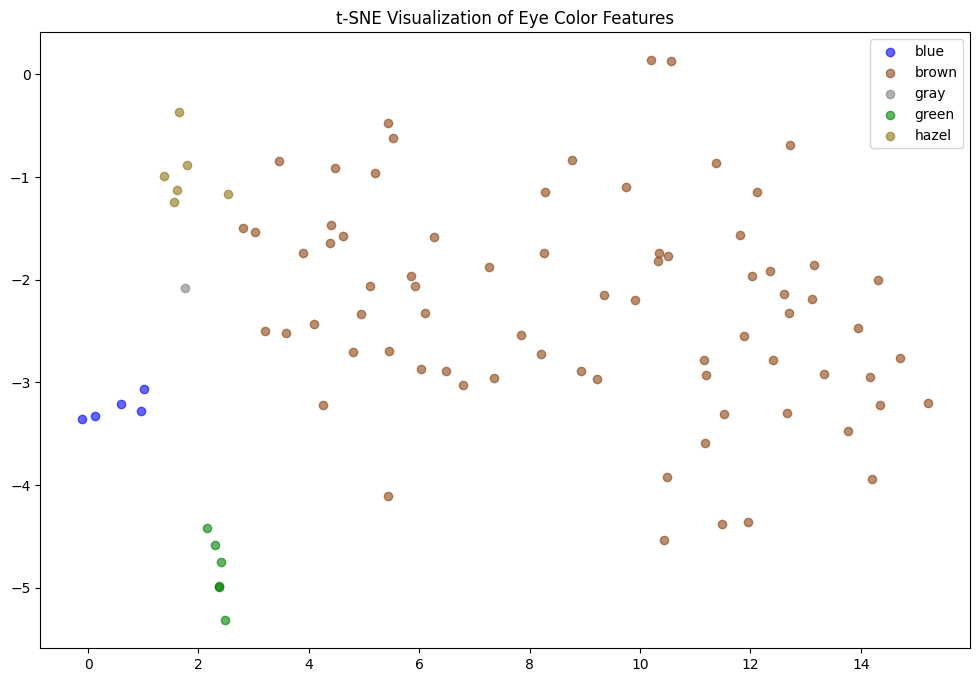

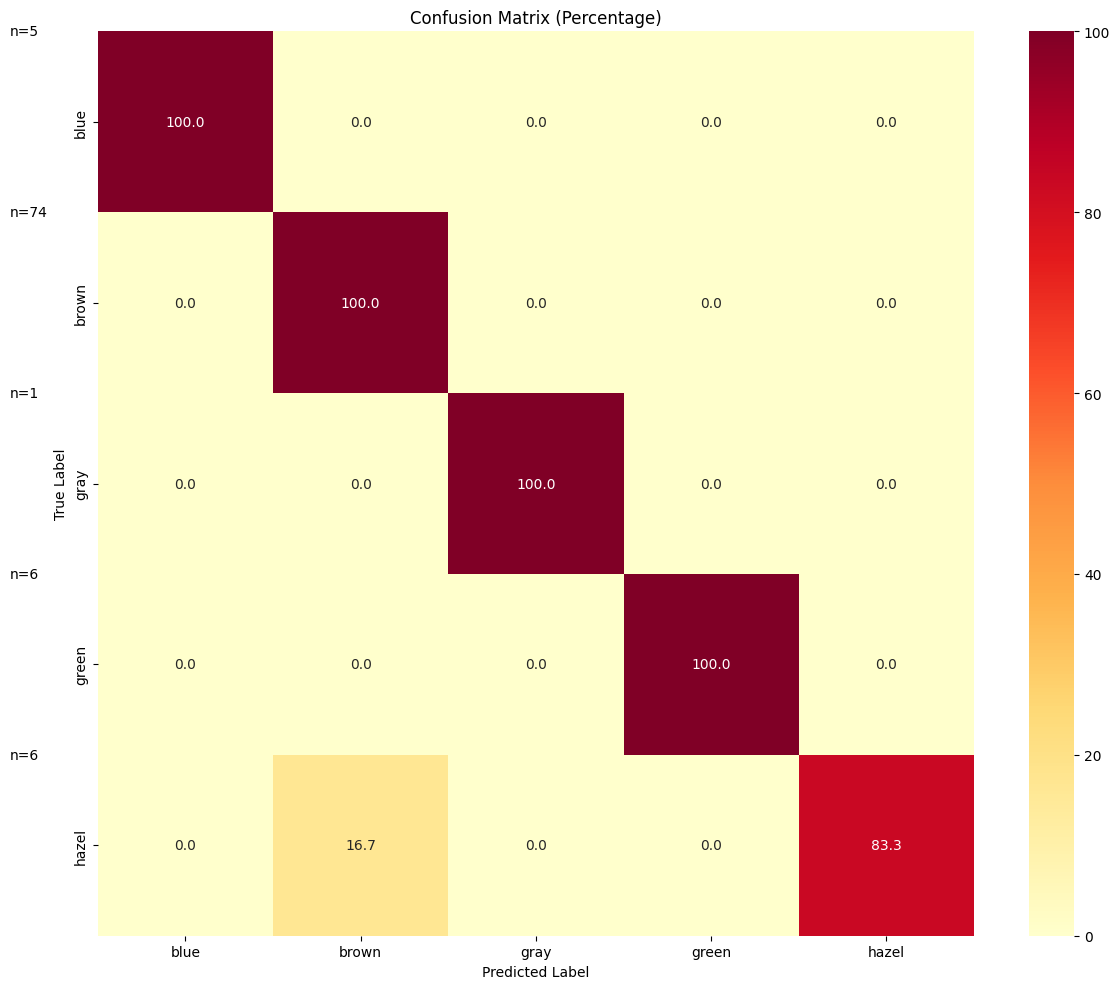

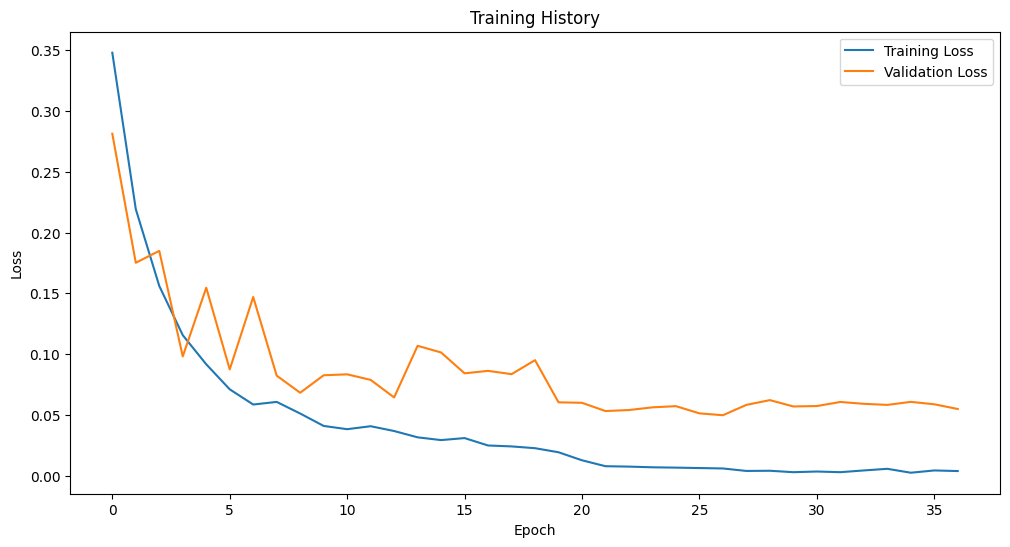

In [ ]:

# Initialize the EyeColorVisualizer
model_path = '/content/drive/MyDrive/ML final project/Trained_models/Classifier/best_eye_color_classifier3.pth'  # Update with your model path
visualizer = EyeColorVisualizer(model_path)

print(f"\nCreating data loader with {len(test_data)} samples")
test_loader = DataLoader(
    test_data,
    batch_size=32,
    shuffle=False,
    num_workers=0,  # Set to 0 for debugging
    drop_last=False,
    collate_fn=lambda x: x[0] if x[0] is not None else None  # Handle None returns
)

print("\nExtracting features...")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

test_features, true_labels, predicted_labels = extract_features_and_predictions(
    visualizer.model,
    test_loader,
    device
)


print("\nCreating visualizations...")
visualizer.plot_feature_space(test_features, true_labels)
visualizer.plot_confusion_matrix(true_labels, predicted_labels)
visualizer.plot_loss_history()

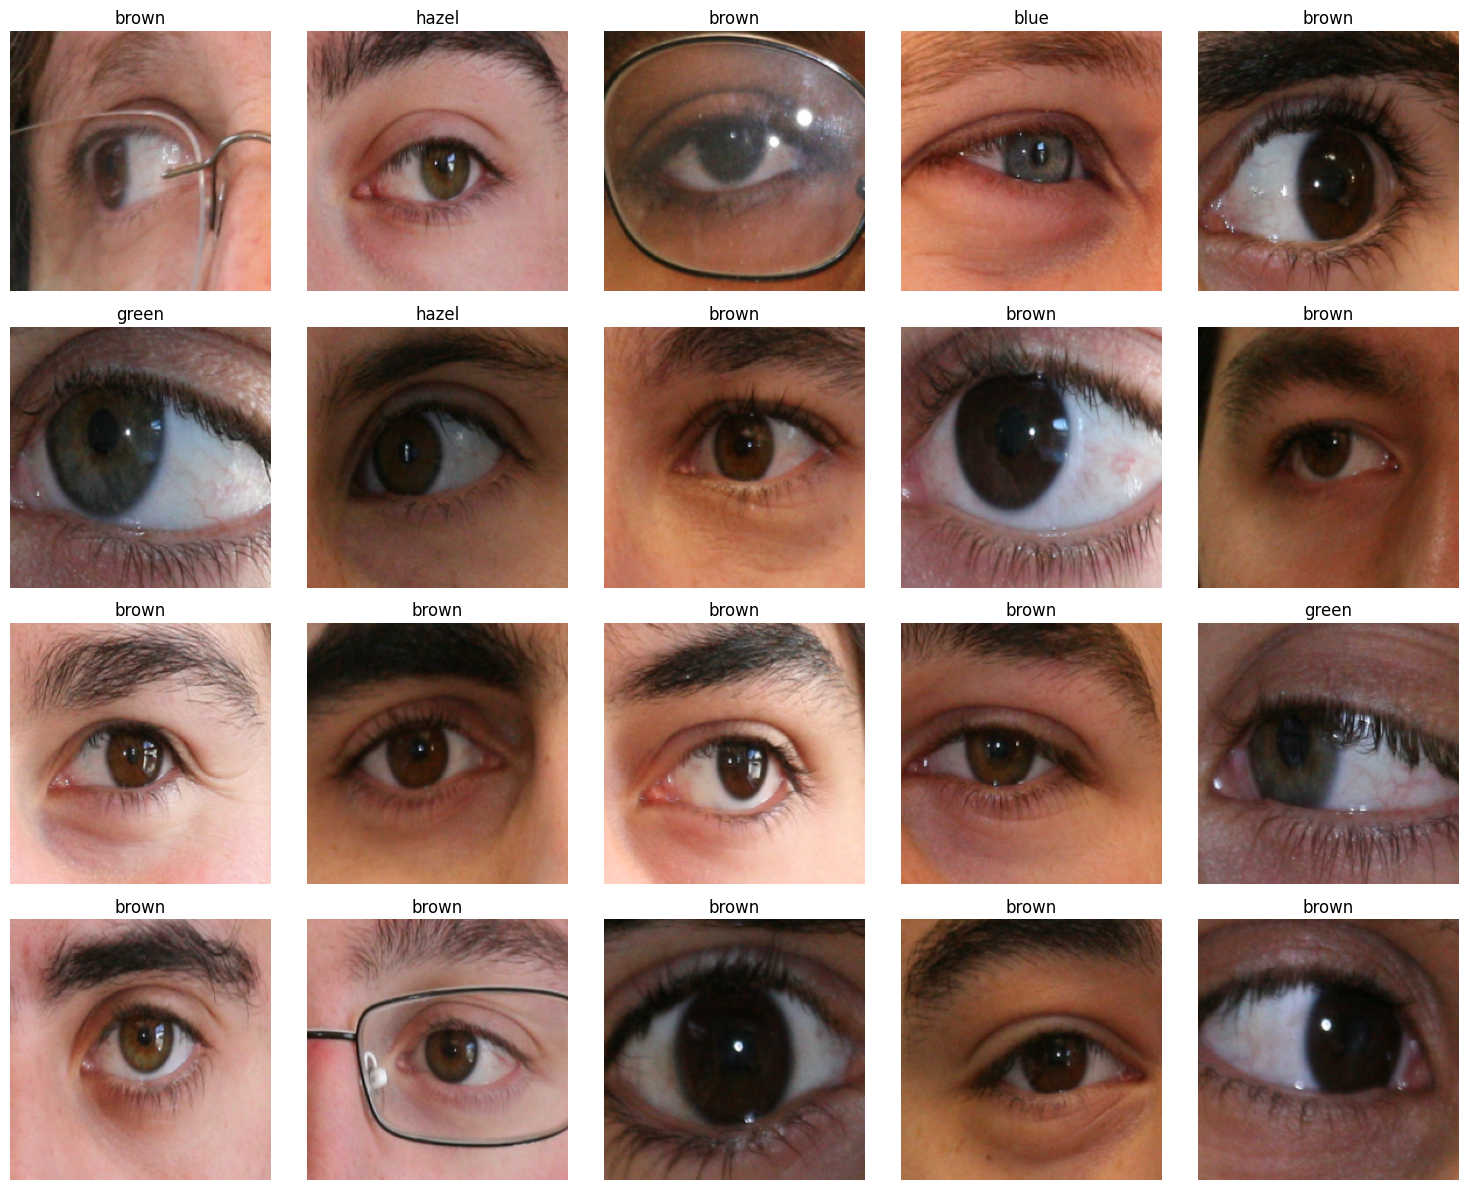

In [ ]:
plot_random_samples(test_data, visualizer.idx_to_color)

In [ ]:
# List contents of the project directory
base_path = '/content/drive/MyDrive/ML final project/Trained_models/Classifier'
print(f"Contents of {base_path}:")
print(os.listdir(base_path))

In [ ]:
import zipfile

# 1. Add class weights to handle imbalance
class_counts = np.bincount(true_labels)
total_samples = len(true_labels)
class_weights = torch.FloatTensor(total_samples / (len(class_counts) * class_counts))
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

# 2. Modify the training data with augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# 3. Implement balanced sampling
class_sample_counts = np.bincount(true_labels)
weights = 1. / class_sample_counts
samples_weights = weights[true_labels]
sampler = WeightedRandomSampler(weights=samples_weights,
                               num_samples=len(true_labels),
                               replacement=True)
with zipfile.ZipFile('/content/drive/MyDrive/ML final project/datasets/EYE_IMAGES_FULL.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/ML final project/datasets/EYE_IMAGES_FULL')  # Extract to a directory

train_dataset = TestDataset(  # Assuming you are reusing your TestDataset class for the training data
    image_dir='/content/drive/MyDrive/ML final project/datasets/EYE_IMAGES_FULL',
    labels_csv='/content/drive/MyDrive/ML final project/datasets/iris_labels_full.csv'
)

# 4. Modify DataLoader to use the sampler
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    sampler=sampler,
    num_workers=4
)

# 5. Add validation metrics
def calculate_metrics(true_labels, predicted_labels):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Per-class metrics
    for idx, class_name in enumerate(color_to_idx.keys()):
        class_precision = precision_score(true_labels, predicted_labels, average=None)[idx]
        class_recall = recall_score(true_labels, predicted_labels, average=None)[idx]
        class_f1 = f1_score(true_labels, predicted_labels, average=None)[idx]
        print(f"\n{class_name}:")
        print(f"Precision: {class_precision:.4f}")
        print(f"Recall: {class_recall:.4f}")
        print(f"F1 Score: {class_f1:.4f}")

KeyboardInterrupt: 

In [ ]:

print("\nCreating visualizations...")
visualizer.plot_feature_space(test_features, true_labels)
visualizer.plot_confusion_matrix(true_labels, predicted_labels)
visualizer.plot_loss_history()

I will now try to improve the confusion matrix using methods such as validation metrics,